In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..')
from f_ring_util import (compute_corrected_ew, 
                         compute_corrected_ew_col,
                         fit_hg_phase_function, 
                         hg_func,
                         print_hg_params)
from matplotlib import rcParams
from matplotlib.lines import Line2D

In [2]:
# Define functions to process data

def remove_eqx(orig_obsdata, eqx_cutoff):
    #remove EQX observations
    #orig_obsdata: original pandas dataframe
    #returns: obsdata (EQX observations removed)
    
    good_i = np.abs(orig_obsdata['Incidence']-90) > eqx_cutoff
    obsdata = orig_obsdata[good_i]
    print('Removed EQX OBSIDs:', set(orig_obsdata[~good_i].groupby('Observation').indices))
    print('Unique observation names:', len(obsdata))
    print()
    
    return obsdata

def remove_outliers(obsdata, outlier_obs):
    #remove 3 outliers from ~phase 50-60 before fitting for tau
    #(located by hand, removing from all 3 by observation name)
    
    for obsid in outlier_obs:
        #drop row containing outlier ob
        obsdata = obsdata[obsdata.index != obsid]
            
    print('Removed outlier OBSIDs:', outlier_obs)
    print('Unique observation names:', len(obsdata))
    print()
    return obsdata

In [3]:
radii = [139470, 140965]
radial_steps = [10]
slice_size = 0

# dump_ew_dir = '/Users/mlessard/REU_2022/data/dump_ew_csv/'
dump_ew_dir = '/seti/src/f-ring/data_files/'

#degrees within 90 (incidence angle) to cut off/get rid of observations
eqx_cutoff = 1.5

#list outlier obsids
outliers = ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']

In [10]:
best_taus = {}
best_taus_radii = {}
mean_ews = {}
for radial_step in radial_steps:
    filepath = f'{dump_ew_dir}ew_stats_{radii[0]}_{radii[1]}_{slice_size}_{radial_step}.csv'

    #extract cols from data
    full_orig_obsdata = pd.read_csv(filepath, parse_dates=['Date'], index_col='Observation')
    
    full_orig_obsdata['Mu'] = np.abs(np.cos(np.radians(full_orig_obsdata['Mean Emission'])))
    full_orig_obsdata['Mu0'] = np.abs(np.cos(np.radians(full_orig_obsdata['Incidence'])))

    #print initial statistics
    print('** SUMMARY STATISTICS **')
    print('Unique observation names:', len(full_orig_obsdata.groupby('Observation')))
    print('Total slices:', len(full_orig_obsdata))
    print('Starting date:', full_orig_obsdata['Date'].min())
    print('Ending date:', full_orig_obsdata['Date'].max())
    print('Time span:', full_orig_obsdata['Date'].max()-full_orig_obsdata['Date'].min())
    print()

    print(filepath)
    print()

    #remove EQX observations
    removed_eqx_obsdata = remove_eqx(full_orig_obsdata, eqx_cutoff)

    #remove outliers
    obsdata = remove_outliers(removed_eqx_obsdata, outliers)

    # Find "small" (<6) e or i
    low_phase_mask = obsdata['Mean Phase'] <= 60
    low_phase_obsdata = obsdata[low_phase_mask]
    lp_low_e_mask = np.abs(low_phase_obsdata['Mean Emission']-90) < 6
    lp_low_i_mask = np.abs(low_phase_obsdata['Incidence']-90) < 6
    lp_low_ei_mask = lp_low_e_mask | lp_low_i_mask

    low_e_mask = np.abs(obsdata['Mean Emission']-90) < 6
    low_i_mask = np.abs(obsdata['Incidence']-90) < 6
    low_ei_mask = low_e_mask | low_i_mask

    best_taus[radial_step] = []
    best_taus_radii[radial_step] = []
    mean_ews[radial_step] = []
    for radius_start in range(radii[0], radii[1], radial_step):
        # Find the optimal tau to minimize scatter
        # only apply the tau correction to the core/Region 2, but use all 3's values to optimize w/ slope/scatter/etc.
        # also only use the low-phase data to calculate
        best_tau = None
        best_slope = 1e38
        for tau in np.arange(0.000, 0.301, 0.001):

            #get the tau-adjusted EW values for the core/Region 2
            corrected_ew = compute_corrected_ew_col(low_phase_obsdata, col_tau=(f'Normal EW{radius_start}', tau)) 

            coeff = np.polyfit(low_phase_obsdata['Mu0'], corrected_ew, 1)
            if abs(coeff[0]) < best_slope:
                best_slope = abs(coeff[0])
                best_tau = tau
            #print(f'Tau {tau:.3f} - Slope: {coeff[0]:8.5f}')

        best_taus_radii[radial_step].append(radius_start + radial_step/2)
        best_taus[radial_step].append(best_tau)
        mean_ews[radial_step].append(low_phase_obsdata[f'Normal EW{radius_start}'].mean())
        print(f'** {radius_start} Best Tau: {best_tau:.3f}')
    best_taus_radii[radial_step] = np.array(best_taus_radii[radial_step])
    best_taus[radial_step] = np.array(best_taus[radial_step])
    mean_ews[radial_step] = np.array(mean_ews[radial_step])

** SUMMARY STATISTICS **
Unique observation names: 151
Total slices: 151
Starting date: 2004-06-20 20:03:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 15:43:39

/seti/src/f-ring/data_files/ew_stats_139470_140965_0_10.csv

Removed EQX OBSIDs: {'ISS_111RF_FMOVIE002_PRIME', 'ISS_112RF_FMOVIE002_PRIME_1', 'ISS_112RF_FMOVIE002_PRIME_2', 'ISS_114RF_FMOVIEEQX001_PRIME', 'ISS_115RF_FMOVIEEQX001_PRIME', 'ISS_110RF_FMOVIE002_PRIME'}
Unique observation names: 145

Removed outlier OBSIDs: ['ISS_091RF_FMOVIE003_PRIME', 'ISS_107RF_FMOVIE002_PRIME', 'ISS_189RF_FMOVIE001_PRIME']
Unique observation names: 142

** 139470 Best Tau: 0.000
** 139480 Best Tau: 0.000
** 139490 Best Tau: 0.000
** 139500 Best Tau: 0.000
** 139510 Best Tau: 0.000
** 139520 Best Tau: 0.000
** 139530 Best Tau: 0.000
** 139540 Best Tau: 0.000
** 139550 Best Tau: 0.000
** 139560 Best Tau: 0.000
** 139570 Best Tau: 0.000
** 139580 Best Tau: 0.000
** 139590 Best Tau: 0.000
** 139600 Best Tau: 0.000
** 139610 Best Tau: 0.00

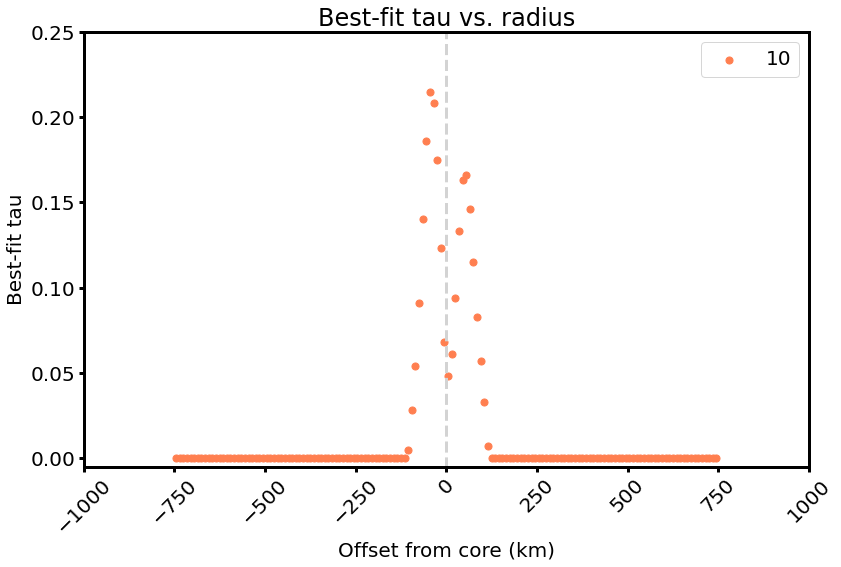

In [13]:
colors = ['coral', 'darkturquoise', 'indigo', 'teal']

plt.figure(0, figsize=(13,8))
ax = plt.axes()
plt.rcParams.update({'font.size': 20})
plt.setp(ax.spines.values(), linewidth=3)
ax.xaxis.set_tick_params(width=3, length=5)
ax.yaxis.set_tick_params(width=3, length=5)

#plot the location of the core
plt.vlines(0, ymin=-0.006,ymax=1.006, lw=3, ls='dashed', colors=['lightgray'])

for i, radial_step in enumerate(best_taus):
    plt.scatter(np.array(best_taus_radii[radial_step])-140220, best_taus[radial_step], s=50, c=colors[i], label=str(radial_step)) #, cmap='magma', edgecolor='black')

#cbar = plt.colorbar()
#cbar.outline.set_linewidth(3)
#cbar.set_label(label='# unique observations')
#cbar.ax.tick_params(width=3, length=5)

plt.title('Best-fit tau vs. radius')
plt.xlabel('Offset from core (km)')
plt.ylabel('Best-fit tau')
plt.xlim(-1000,1000)
plt.ylim(-0.005, 0.25)
plt.xticks(rotation=45)

plt.legend()

plt.show()

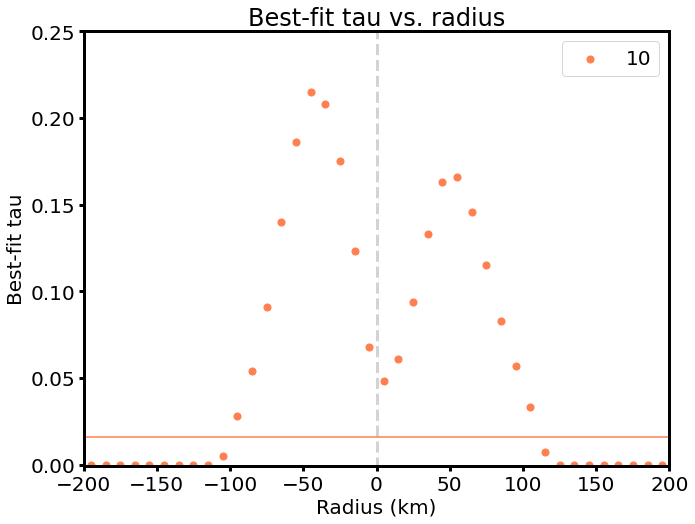

In [14]:
#plot again, but cut off the edges to look at the shape of the curve for the core better
plt.figure(1, figsize=(10.5,8))
ax = plt.axes()
plt.rcParams.update({'font.size': 20})
plt.setp(ax.spines.values(), linewidth=3)
ax.xaxis.set_tick_params(width=3, length=5)
ax.yaxis.set_tick_params(width=3, length=5)

#plot the location of the core
plt.vlines(0, ymin=-0.002, ymax=1.001, lw=3, ls='dashed', colors=['lightgray'])

#plot the data
for i, radial_step in enumerate(best_taus):
    plt.scatter(best_taus_radii[radial_step]-140220, best_taus[radial_step], s=50, c=colors[i], label=str(radial_step)) #, cmap='magma', edgecolor='black')
    
#plot average of all 10-km-slice points (see if it ~ equals best_tau=0.021 like was found for 400-km core)
    av_tau = np.mean(best_taus[radial_step])
    plt.hlines(y=av_tau, xmin=-200, xmax=200, colors=[colors[i]])

plt.title('Best-fit tau vs. radius')
plt.xlabel('Radius (km)')
plt.ylabel('Best-fit tau')
plt.xlim(-200,200)
plt.ylim(-0.001,0.25)

plt.legend()

plt.show()

In [15]:
#plot the number of observations as a function of radius for the iterative runs
"""
plt.figure(2, figsize=(10.5,8))
ax = plt.axes()
plt.rcParams.update({'font.size': 20})
plt.setp(ax.spines.values(), linewidth=3)
ax.xaxis.set_tick_params(width=3, length=5)
ax.yaxis.set_tick_params(width=3, length=5)

#plot the location of the core
plt.vlines(0, ymin=-0.002,ymax=151, lw=3, ls='dashed', colors=['lightgray'])

#plot the data
plt.scatter(radii, unique_obs, s=50, c='teal')

plt.title('Number of unique observations vs. radius')
plt.xlabel('Radius (km)')
plt.ylabel('# Unique Obs')
plt.xticks(rotation=45)
plt.ylim(0,150)

plt.show()
"""

"\nplt.figure(2, figsize=(10.5,8))\nax = plt.axes()\nplt.rcParams.update({'font.size': 20})\nplt.setp(ax.spines.values(), linewidth=3)\nax.xaxis.set_tick_params(width=3, length=5)\nax.yaxis.set_tick_params(width=3, length=5)\n\n#plot the location of the core\nplt.vlines(0, ymin=-0.002,ymax=151, lw=3, ls='dashed', colors=['lightgray'])\n\n#plot the data\nplt.scatter(radii, unique_obs, s=50, c='teal')\n\nplt.title('Number of unique observations vs. radius')\nplt.xlabel('Radius (km)')\nplt.ylabel('# Unique Obs')\nplt.xticks(rotation=45)\nplt.ylim(0,150)\n\nplt.show()\n"

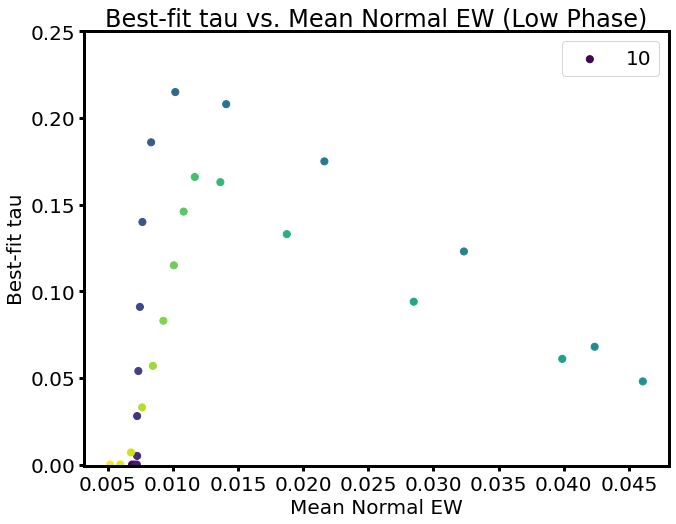

In [18]:
plt.figure(1, figsize=(10.5,8))
ax = plt.axes()
plt.rcParams.update({'font.size': 20})
plt.setp(ax.spines.values(), linewidth=3)
ax.xaxis.set_tick_params(width=3, length=5)
ax.yaxis.set_tick_params(width=3, length=5)
ok = np.abs(best_taus_radii[radial_step]-140220) < 140
for i, radial_step in enumerate(best_taus):
    plt.scatter(mean_ews[radial_step][ok], best_taus[radial_step][ok], s=50, c=best_taus_radii[radial_step][ok], label=str(radial_step)) #, cmap='magma', edgecolor='black')
    
plt.title('Best-fit tau vs. Mean Normal EW (Low Phase)')
plt.xlabel('Mean Normal EW')
plt.ylabel('Best-fit tau')
# plt.xlim(-200,200)
plt.ylim(-0.001,0.25)

plt.legend()

plt.show()

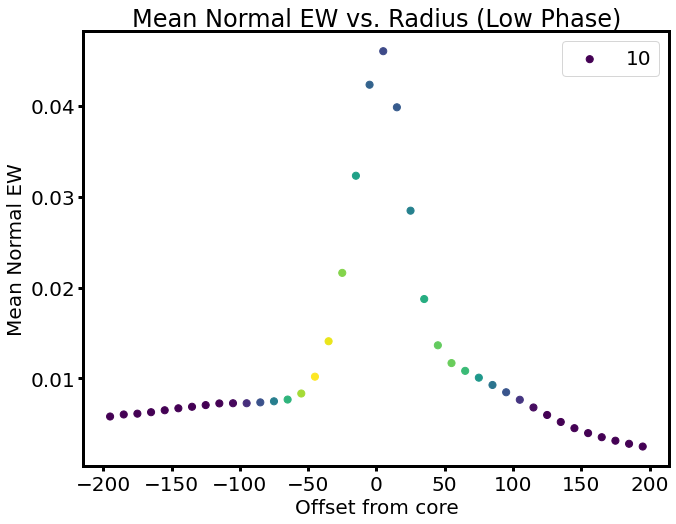

In [17]:
plt.figure(1, figsize=(10.5,8))
ax = plt.axes()
plt.rcParams.update({'font.size': 20})
plt.setp(ax.spines.values(), linewidth=3)
ax.xaxis.set_tick_params(width=3, length=5)
ax.yaxis.set_tick_params(width=3, length=5)
ok = np.abs(best_taus_radii[radial_step]-140220) < 200
for i, radial_step in enumerate(best_taus):
    plt.scatter(best_taus_radii[radial_step][ok]-140220, mean_ews[radial_step][ok], s=50, c=best_taus[radial_step][ok], label=str(radial_step)) #, cmap='magma', edgecolor='black')
    
plt.title('Mean Normal EW vs. Radius (Low Phase)')
plt.ylabel('Mean Normal EW')
plt.xlabel('Offset from core')
# plt.xlim(-200,200)
# plt.ylim(-0.001,0.075)

plt.legend()

plt.show()